In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.feature_selection import RFE

In [4]:
df = pd.read_csv("data/time_domain_features_holter.csv")
y = df["died"].values
X = df.drop(["ID", "died"], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
X.shape

(176, 64)

## Utils


In [ ]:
from importlib import reload
import utils

reload(utils)

from utils import (
    preprocess,
    find_best_fold,
    calculate_metrics,
    plot_confusion_matrix,
    display_kfold_scores,
    apply_grid_search,
    extract_params_and_k,
    get_kfold_results,
    gmean_scorer,
    CorrelationFeatureReducer
)


from sklearn.decomposition import PCA

## Constants


In [22]:
MODEL_PREFIX = "clf"
K_KEY = "select__n_features_to_select"
REDUCTION_TYPE = "rfe"

SELECTOR_MAP = {
    "kbest": SelectKBest(f_classif),
    "corr": CorrelationFeatureReducer(),
    "pca": PCA(),
    "rfe": None,
}

SELECTOR = SELECTOR_MAP[REDUCTION_TYPE]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Logistic Regression


In [16]:
base_model = LogisticRegression(
    solver="liblinear", max_iter=1000, random_state=42
)
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("select", SELECTOR if REDUCTION_TYPE != "rfe" else RFE(base_model)),
        ("clf", LogisticRegression(solver="liblinear", max_iter=1000, random_state=42)),
    ]
)

param_grid = {
    "select__n_features_to_select": [10, 20, 30, 40, 50, X.shape[-1]],
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.001, 0.01, 0.1, 1, 10],
    "clf__class_weight": [None, "balanced"],
}

params = apply_grid_search(
    X_train, y_train, estimator=pipeline, param_grid=param_grid, scoring='f1'
)

best_params, best_k = extract_params_and_k(params, MODEL_PREFIX, K_KEY)

print(f"Best params: {best_params}")
print(f"Best k: {best_k}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best score: 0.8122352941176472
Best params: {'C': 0.1, 'class_weight': None, 'penalty': 'l1'}
Best k: 10


In [23]:
X_train_, X_test_ = preprocess(
    X_train, X_test, y_train, k=best_k, reduction_type=REDUCTION_TYPE, estimator=base_model
)

model = LogisticRegression(
    solver="liblinear", max_iter=1000, random_state=42, **best_params
)
model.fit(X_train_, y_train)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test, y_pred, display=True)

Accuracy: 80.56
Precision: 69.23
Recall: 75.00
Specificity: 83.33
F1 Score: 72.00
Geometric Mean: 79.06


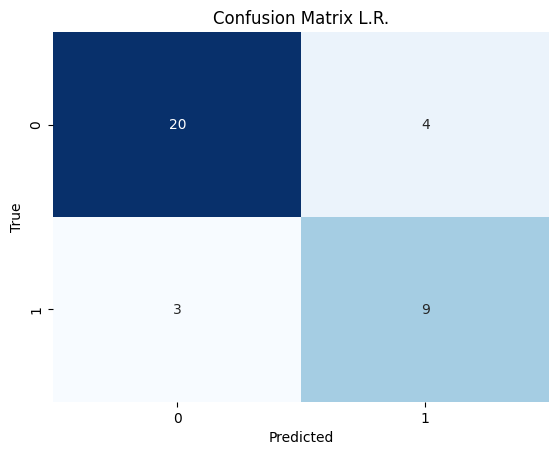

In [19]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix L.R.")

In [25]:
metrics = get_kfold_results(
    model=LogisticRegression(
        solver="liblinear", max_iter=1000, random_state=42, **best_params
    ),
    X=X_train,
    y=y_train,
    cv=cv,
    best_k=best_k,
    preprocess_reduction_type=REDUCTION_TYPE,
    preprocess_estimator=base_model,
)

display_kfold_scores(metrics)

K-Fold Results
Accuracy: 84.29 ± 9.74
Precision: 74.20 ± 18.33
Recall: 93.56 ± 5.28
Specificity: 79.71 ± 15.37
F1 Score: 81.22 ± 10.44
Geometric Mean: 85.81 ± 7.44


In [27]:
best_fold, idx_best_fold = find_best_fold(
    cv.split(X_train, y_train), metrics, eval_metric="f1"
)
print(f"Best fold: {idx_best_fold + 1}")

train_idx, test_idx = best_fold
X_train_ = X_train[train_idx]
X_test_ = X_train[test_idx]
y_train_ = y_train[train_idx]
y_test_ = y_train[test_idx]

X_train_, X_test_ = preprocess(
    X_train_, X_test_, y_train_, k=best_k, reduction_type=REDUCTION_TYPE, estimator=base_model
)
model = LogisticRegression(
    solver="liblinear", max_iter=1000, random_state=42, **best_params
)
model.fit(X_train_, y_train_)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test_, y_pred, display=True)

Best fold: 3
Accuracy: 96.43
Precision: 100.00
Recall: 88.89
Specificity: 100.00
F1 Score: 94.12
Geometric Mean: 94.28


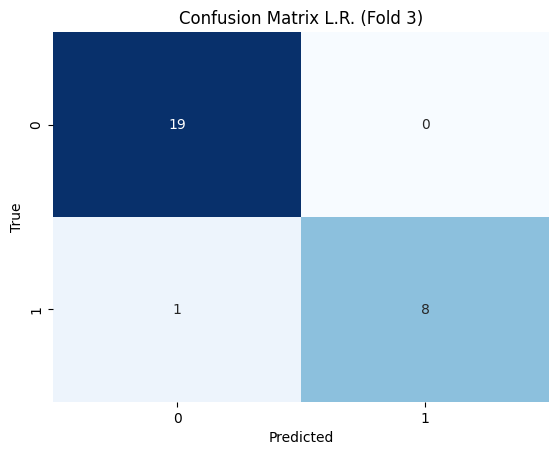

In [28]:
plot_confusion_matrix(
    y_test_, y_pred, title=f"Confusion Matrix L.R. (Fold {idx_best_fold + 1})"
)

## SVC


> It will only work with RFE if kernel is linear (coef_)

In [29]:
base_model = SVC(random_state=42)
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("select", SELECTOR if REDUCTION_TYPE != "rfe" else RFE(base_model)),
        ("clf", SVC(random_state=42)),
    ]
)

param_grid = {
    "select__n_features_to_select": [10, 20, 30, 40, 50, X.shape[-1]],
    "clf__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "clf__gamma": ["scale", "auto"],
    "clf__class_weight": [None, "balanced"],
}

params = apply_grid_search(
    X_train, y_train, estimator=pipeline, param_grid=param_grid, scoring='f1'
)

best_params, best_k = extract_params_and_k(params, MODEL_PREFIX, K_KEY)

print(f"Best params: {best_params}")
print(f"Best k: {best_k}")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best score: 0.6877364953886692
Best params: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
Best k: 64


d:\scd-feature-reduction\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
2400 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2400 fits failed with the following error:
Traceback (most recent call last):
  File "d:\scd-feature-reduction\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\scd-feature-reduction\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\scd-feature-reduction\.venv\Lib\site-packages\sklearn\pipeline.py", line 654, in fit

In [31]:
X_train_, X_test_ = preprocess(
    X_train, X_test, y_train, k=best_k, reduction_type=REDUCTION_TYPE, estimator=base_model
)


model = SVC(random_state=42, **best_params)


model.fit(X_train_, y_train)


y_pred = model.predict(X_test_)


_ = calculate_metrics(y_test, y_pred, display=True)

Accuracy: 75.00
Precision: 60.00
Recall: 75.00
Specificity: 75.00
F1 Score: 66.67
Geometric Mean: 75.00


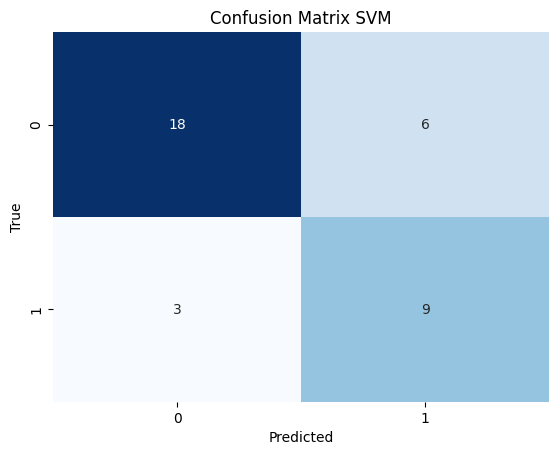

In [32]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix SVM")

In [33]:
metrics = get_kfold_results(
    model=SVC(random_state=42, **best_params),
    X=X_train,
    y=y_train,
    cv=cv,
    best_k=best_k,
    preprocess_reduction_type=REDUCTION_TYPE,
    preprocess_estimator=base_model,
)

display_kfold_scores(metrics)

K-Fold Results
Accuracy: 75.00 ± 5.05
Precision: 59.76 ± 6.32
Recall: 82.89 ± 12.60
Specificity: 70.99 ± 8.44
F1 Score: 68.77 ± 6.00
Geometric Mean: 76.15 ± 5.06


In [34]:
best_fold, idx_best_fold = find_best_fold(
    cv.split(X_train, y_train), metrics, eval_metric="f1"
)
print(f"Best fold: {idx_best_fold + 1}")

train_idx, test_idx = best_fold
X_train_ = X_train[train_idx]
X_test_ = X_train[test_idx]
y_train_ = y_train[train_idx]
y_test_ = y_train[test_idx]

X_train_, X_test_ = preprocess(
    X_train_, X_test_, y_train_, k=best_k, reduction_type=REDUCTION_TYPE, estimator=base_model
)
model = SVC(random_state=42, **best_params)
model.fit(X_train_, y_train_)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test_, y_pred, display=True)

Best fold: 5
Accuracy: 82.14
Precision: 66.67
Recall: 100.00
Specificity: 72.22
F1 Score: 80.00
Geometric Mean: 84.98


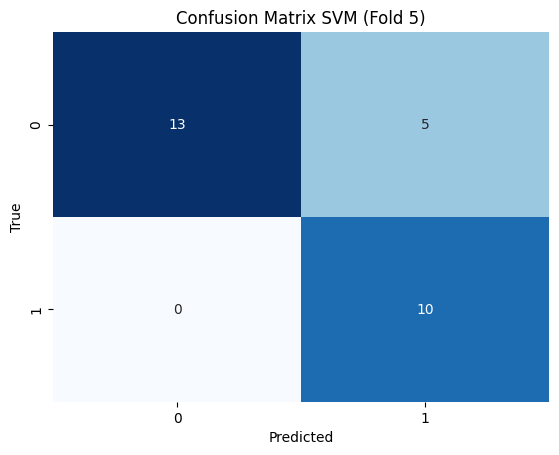

In [35]:
plot_confusion_matrix(
    y_test_, y_pred, title=f"Confusion Matrix SVM (Fold {idx_best_fold + 1})"
)

## KNN


> KNN doesnt provides information about feature importance (e.g. `coef_`, `feature_importances_`).

In [36]:
base_model = KNeighborsClassifier()
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("select", SELECTOR if REDUCTION_TYPE != "rfe" else RFE(base_model)),
        ("clf", KNeighborsClassifier()),
    ]
)

param_grid = {
    "select__n_features_to_select": [10, 20, 30, 40, 50, X.shape[-1]],
    "clf__n_neighbors": [3, 5, 7, 9, 11, 13],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2, 3],
}

params = apply_grid_search(
    X_train, y_train, estimator=pipeline, param_grid=param_grid, scoring='f1'
)

best_params, best_k = extract_params_and_k(params, MODEL_PREFIX, K_KEY)

print(f"Best params: {best_params}")
print(f"Best k: {best_k}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best score: 0.31227554179566563
Best params: {'n_neighbors': 3, 'p': 3, 'weights': 'uniform'}
Best k: 64


d:\scd-feature-reduction\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
900 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "d:\scd-feature-reduction\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\scd-feature-reduction\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\scd-feature-reduction\.venv\Lib\site-packages\sklearn\pipeline.py", line 654, in fit
 

In [38]:
X_train_, X_test_ = preprocess(
    X_train, X_test, y_train, k=best_k, reduction_type=REDUCTION_TYPE, estimator=base_model
)


model = KNeighborsClassifier(**best_params)

model.fit(X_train_, y_train)


y_pred = model.predict(X_test_)

_ = calculate_metrics(y_test, y_pred, display=True)

Accuracy: 69.44
Precision: 53.33
Recall: 66.67
Specificity: 70.83
F1 Score: 59.26
Geometric Mean: 68.72


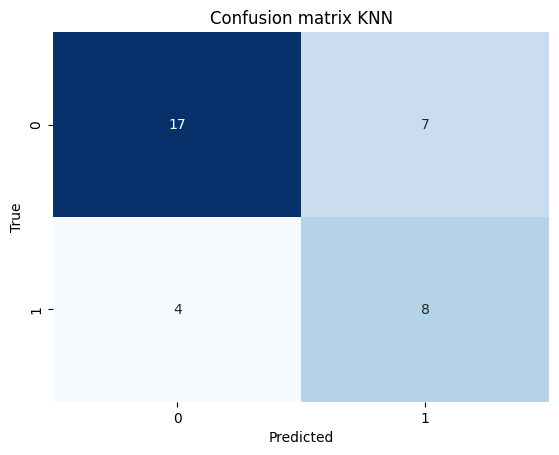

In [39]:
plot_confusion_matrix(y_test, y_pred, "Confusion matrix KNN")

In [40]:
metrics = get_kfold_results(
    model=KNeighborsClassifier(**best_params),
    X=X_train,
    y=y_train,
    cv=cv,
    best_k=best_k,
    preprocess_reduction_type=REDUCTION_TYPE,
    preprocess_estimator=base_model,
)

display_kfold_scores(metrics)

K-Fold Results
Accuracy: 60.00 ± 8.57
Precision: 37.43 ± 20.79
Recall: 27.33 ± 14.05
Specificity: 76.49 ± 8.90
F1 Score: 31.23 ± 16.38
Geometric Mean: 41.32 ± 21.02


In [41]:
best_fold, idx_best_fold = find_best_fold(
    cv.split(X_train, y_train), metrics, eval_metric="f1"
)
print(f"Best fold: {idx_best_fold + 1}")

train_idx, test_idx = best_fold
X_train_ = X_train[train_idx]
X_test_ = X_train[test_idx]
y_train_ = y_train[train_idx]
y_test_ = y_train[test_idx]

X_train_, X_test_ = preprocess(
    X_train_, X_test_, y_train_, k=best_k, reduction_type=REDUCTION_TYPE, estimator=base_model
)
model = KNeighborsClassifier(**best_params)
model.fit(X_train_, y_train_)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test_, y_pred, display=True)

Best fold: 5
Accuracy: 67.86
Precision: 57.14
Recall: 40.00
Specificity: 83.33
F1 Score: 47.06
Geometric Mean: 57.74


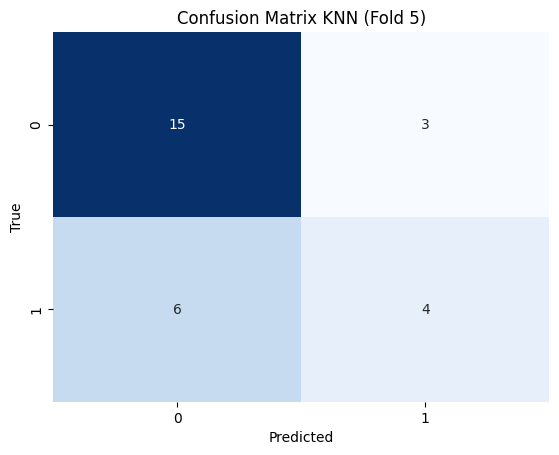

In [42]:
plot_confusion_matrix(
    y_test_, y_pred, title=f"Confusion Matrix KNN (Fold {idx_best_fold + 1})"
)